In [1]:
import numpy as np
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt
import operator
from scipy import optimize

from cohort_model import run_cohort_simulation, get_mean_and_std, HYP_WILDTYPE,  MUT_CAPTIVITY

# Calculations for Figure 1 in technical comment XYZ

**SKRIV FORKLARING PÅ HVA SOM ER I DENNE NOTEBOOKEN**
This notebook contains the calculations used to support the argument in bla bla bla 

Estimate maximum lifespan in captivity under conditions of no environmental mortality

Papers referred to in this notebook are 
- da Silva *et al.* (2022): [R. da Silva, D. A. Conde, A. Baudisch, F. Colchero, Slow and negligible senescence among testudines challenges evolutionary theories of senescence. *Science*. **376**, 1466–1470 (2022)](https://doi.org/10.1126/science.abl7811)
- Omholt and Kirkwood (2021): [S. W. Omholt, T. B. L. Kirkwood, Aging as a consequence of selection to reduce the environmental risk of dying. *Proc. Natl. Acad. Sci. U. S. A.* **118**, 1–9 (2021)](https://doi.org/10.1073/pnas.2102088118)
- Gibbons (1987): [J. W. Gibbons, Why Do Turtles Live So Long? *BioScience*. **37**, 262–269 (1987)](https://doi.org/10.2307/1310589)

## Fit a polynomial function to *Trachemys scripta* mortality risk data
First, we fit polynomial functions to the mortality risk ($\mu(t)$) data for *T. scripta* males and females in captivity using the least squares method. The mortality risk data were extracted from Fig. S2c in Supplementary Materials of da Silva *et al.* (2022).

All age data in this notebook are adjusted to post sexual maturation (psm), such that time *t* = 0 is set to age at first reproduction. For *T. scripta* this is set to 5 years of age, as reported in Table S2 in Supplementary Materials of da Silva *et al.* (2022).

### *T. scripta* males

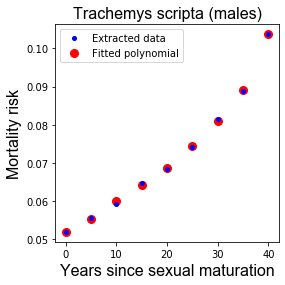

In [2]:
# Extracted mean annual mortality risk for T. scripta males in captivity
years_spaced_m = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40])  # Years psm
annual_mortality_risk_spaced_m = np.array([0.0519, 0.0556, 0.0593, 0.0648, 0.0685, 0.0741, 0.0815, 0.0889, 0.1037])

# Get the least squares polynomial fit to the data
fitted_polynomial_m = Polynomial.fit(x=years_spaced_m, y=annual_mortality_risk_spaced_m, deg=6)

# Evaluate fitted polynomial function values at same years as in extracted data
fitted_polynomial_values_spaced_m = fitted_polynomial_m(years_spaced_m)

# Plot extracted mortality risk data together with the fitted polynomial
# function values to confirm fit
fig,ax = plt.subplots(figsize=(4,4))
font = {"fontname": "Arial", "fontsize": 16}
ax.set_xlabel("Years since sexual maturation", **font)
ax.set_ylabel("Mortality risk", **font)
ax.set_title("Trachemys scripta (males)", **font)

ax.plot(years_spaced_m, annual_mortality_risk_spaced_m, 'bo', zorder=3, markersize=4, label="Extracted data")
ax.plot(years_spaced_m, fitted_polynomial_values_spaced_m, 'ro', markersize=8, label="Fitted polynomial")
ax.legend();

### *T. scripta* females

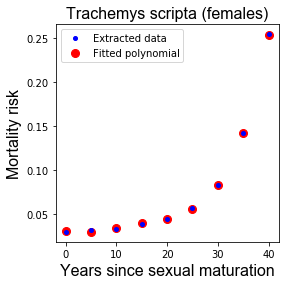

In [3]:
# Extracted mean annual mortality risk for T. scripta females in captivity
years_spaced_f = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40])  # Years psm
annual_mortality_risk_spaced_f = np.array([0.0300, 0.0317, 0.0333, 0.0392, 0.0450, 0.0574, 0.0833, 0.1416, 0.2541])

# Get the least squares polynomial fit to the data:
fitted_polynomial_f = Polynomial.fit(x=years_spaced_f, y=annual_mortality_risk_spaced_f, deg=4)

# Evaluate fitted polynomial function values at same years as in extracted data:
fitted_polynomial_values_spaced_f = fitted_polynomial_f(years_spaced_f)

# Plot extracted mortality risk data from Fig. S2c together with the fitted polynomial
# function values to confirm fit
fig,ax = plt.subplots(figsize=(4,4))
font = {"fontname": "Arial", "fontsize": 16}
ax.set_xlabel("Years since sexual maturation", **font)
ax.set_ylabel("Mortality risk", **font)
ax.set_title("Trachemys scripta (females)", **font)

ax.plot(years_spaced_f, annual_mortality_risk_spaced_f, 'bo', zorder=3, markersize=4, label="Extracted data")
ax.plot(years_spaced_f, fitted_polynomial_values_spaced_f, 'ro', markersize=8, label="Fitted polynomial")
ax.legend();

## Use fitted polynomial function to find estimates of $\alpha$ and $\kappa$ values for the hazard rate equation 

Assuming a constant environmental mortality equal to the reported initial mortality risk ($\mu(0)$), we least-squares fit the mortality risk data to the hazard rate equation in Omholt and Kirkwood (2021), i.e.

$$
h(t) = \mu(0) + \alpha [(1 + \kappa)^{t + 1} - 1]
$$

where the second term describes the accumulation of somatic damage as a function of age (see Omholt and Kirkwood (2021) for the derivation of this equation). 

The first step is to evaluate the fitted polynomial at years 0 through 40 to obtain the annual $\mu(t)$ values in the data.

The second step is to perform least-squares fitting, using these $\mu(t)$ values as our data and the hazard rate equation (above) as the function to be fitted, for the two parameters $\alpha$ and $\kappa$. 

Assuming constant environmental mortality equal to the reported initial mortality, any increase in mortality in the data is assumed to stem from senescence through accumulation of somatic damage.

When values for $\alpha$ and $\kappa$ have been found, we can use the hazard rate equation with $\mu(0) = 0$ to find the mortality risk associated with senescence only. From this we estimate the survivorship curve and maximum lifespan of the species under conditions of no environmental mortality displayed in Figure 1 below.

### *T. scripta* males
For *T. scripta* males, the initial mortality risk ($\mu(0)$) is 0.0519. 

In [4]:
# 1. Obtain annual mu(t) values
years_m = np.arange(41)        # Years 0 through 40 psm
fitted_polynomial_values_m = fitted_polynomial_m(years_m) # Annual mortality risk 

# Define function to be fitted to data
def hazard_rate_m(t, alpha, kappa):
     return annual_mortality_risk_spaced_m[0] + alpha * (((1 + kappa) ** (t + 1)) - 1)

# 2. Fit hazard rate function to mu(t) data using least squares method
alpha_m, kappa_m = optimize.curve_fit(hazard_rate_m, xdata=years_m, ydata=fitted_polynomial_values_m)[0]

print("T. scripta males:")
print(f"alpha: {alpha_m:.4f}")
print(f"kappa: {kappa_m:.4f}")

T. scripta males:
alpha: 0.0154
kappa: 0.0353


### *T. scripta* females
For *T. scipta* females, the initial morality risk ($\mu(0)$) is 0.03.

In [5]:
# 1. Obtain annual mu(t) values
years_f = np.arange(41)        # Years 0 through 40 psm
fitted_polynomial_values_f = fitted_polynomial_f(years_f) # Annual mortality risk 

# Define function to be fitted to data
def hazard_rate_f(t, alpha, kappa):
     return annual_mortality_risk_spaced_f[0] + alpha * (((1 + kappa) ** (t + 1)) - 1)

# 2. Fit hazard rate function to mu(t) data using least squares method
alpha_f, kappa_f = optimize.curve_fit(hazard_rate_f, xdata=years_f, ydata=fitted_polynomial_values_f)[0]

print("T. scripta females:")
print(f"alpha: {alpha_f:.4f}")
print(f"kappa: {kappa_f:.4f}")

T. scripta females:
alpha: 0.0008
kappa: 0.1493


## Obtaining an estimate of environmental mortality for wild *T. scripta* assuming no senescence

Survivorship data for wild *T. scripta* (both sexes) in the Ellenton Bay location were extracted from Gibbons (1987), Fig. 3 lower panel.

We extracted values at 0, 2.5, 5, 7.5, 10, 15 and 20 years after sexual maturation (assumed at 5 years of age) and transformed the data to a normal cohort survivorship form.

Using a discrete time stochastic process model with a constant environmental mortality risk, we can model the survivorship curve for a range of environmental mortalities. We iterate through the range of putative environmental mortalities and calculate the best least-squares fit to the three first data points (0, 2.5 and 5 years psm). We avoid fitting to data from any later than 5 years after sexual maturation for *T. scripta* in order to estimate only the environmental mortality and not any possible effects on mortality from senescence later in life. 

The rationale of the discrete time stochastic process model is described in Omholt and Kirkwood (2021), and the model is implemented in the `run_cohort_simulation` function in the `cohort_model` module of this repository.

In [6]:
# Extracted data for T. scripta (both sexes) in the wild - Ellenton Bay location
gibbons_years = [0, 2.5, 5, 7.5, 10, 15, 20]   # Years psm
gibbons_survivorship = [1.0, 0.5957, 0.3548, 0.1778, 0.0891, 0.0158, 0.004]   # Normalized cohort survivorship 

In [ ]:
%%time
repetition_count = 1000
individual_count = 1000
t_max_w = 21 

fit_results = []
for hazard_rate in np.arange(0.1, 0.5, 0.0001): 
    hazard_rate_params = dict(hazard_rate_wt=hazard_rate, population=HYP_WILDTYPE)
    simulation = run_cohort_simulation(
                    repetition_count=repetition_count, 
                    individual_count=1000, 
                    hazard_rate_params=hazard_rate_params, 
                    t_m=t_max_w)
    mean = get_mean_and_std(simulation)[0]
    sum_square = ((mean[0] - gibbons_survivorship[0])**2 + 
                  ((mean[2] + mean[3]) / 2 - gibbons_survivorship[1])**2 + 
                  (mean[5] - gibbons_survivorship[2])**2)
    fit_results.append((hazard_rate, sum_square))  # Store the obtained sum of squares for comparison
    
best_fits = sorted(fit_results, key=operator.itemgetter(1))
print("Best fits for hazard rate product, T. scripta males")
print(*best_fits[:5], sep = "\n")

## TITTEL??? STIG SKRIV INN TEKST! :) 


tre formål:
det vi oppnår med det vi har gjort over er 
1. vi får formen på S(t) senescence only (in captivity) for både females og males
2. vi får tidspunktet (året) for når S(t) er omtrent 0.01 (max lifespan)
3. derved får vi stipulert maximum lifespan with no environmental mortality

Da har vi to verdier som vi kan sammenligne mot maximum lifespan in the wild. For å se om forskjellen er markant forskjelling fra det vi observerer i andre organismer - In a phylogenetically wide range of species. 

Det ytterlige aspektet med øvelsen er å se om wild t scripta populasjonen viser tegn til senescence eller ikke. 

Vi finner formen på survivorship-kurva når det ikke er noe environmental mortality. Som gjør det mulig for oss å sammenligne med kurvene som følger av de rapporterte dataene. 


Den max lifespan in the wild, som gitt ved dataene i Gibbons (1987), men i tillegg gjør vi en tilpasning til dataene med constant environmental mortality for å se om det er tegn til senescence også i den populasjon. 

Som en forberedelse til fortolkning av høyre panel av figur 2, har vi også lagt inn...

**SLETT:**

In the above, we have fitted a polynomial function to mortality risk data for T. scripta in captivity and used this to obtain values for alpha, kappa. 

This allows us to compare the survivorship curves of T. scripta in three scenarios:
1. in the wild, with a high environmental mortality risk
2. in captivity, with a lower environmental mortality risk than in the wild, and
3. in a hypothetical population with an environmental mortality risk of 0, with mortality stemming from senescence only

We have also estimated a constant environmental mortality risk for Trachemys scripta males and females based on data from the first 10 years of life of a wild population. This allows us to compare the actual reported survivorship curve with our model's prediction of the survivorship curve assuming no senescence. If the actual data show lower S(t) at the same time points after 10 years, this indicates senescence. 

### Survivorship curves (S(t)) for *T. scripta* dying from senescence only
Here we use the $\alpha$ and $\kappa$ values estimated above.

In [ ]:
# T. scripta males, senescence only
t_max_m = 74 # After running the model, this is the year (plus 1 year) where S(t) is approximately 0.01
hazard_rate_params = dict(alpha=alpha_m, kappa=kappa_m, population=MUT_CAPTIVITY)
simulation = run_cohort_simulation(repetition_count=1000, 
                                   individual_count=1000, 
                                   hazard_rate_params=hazard_rate_params, 
                                   t_m=t_max_m)

mean_m, std_m = get_mean_and_std(simulation)

In [ ]:
# T. scripa females, senescence only
t_max_f = 43 # After running the model, this is the year (plus 1 year) where S(t) is approximately 0.01
hazard_rate_params = dict(alpha=alpha_f, kappa=kappa_f, population=MUT_CAPTIVITY)
simulation = run_cohort_simulation(repetition_count=1000, 
                                   individual_count=1000, 
                                   hazard_rate_params=hazard_rate_params, 
                                   t_m=t_max_f)

mean_f, std_f = get_mean_and_std(simulation)

### Survivorship curves (S(t)) for *T. scripta* in captivity
Here we use the polynomial functions previously obtained by fitting to the mortality risk data reported by da Silva *et al.* (2022) to calculate survivorship curves for *T. scripta* males and females.

In [ ]:
# T. scripta males, captivity
t_max_cap = 41 # Approximately the highest age psm (plus 1 year) at which da Silva et al. provided mortality risk data
hazard_rate_params = dict(population="", expression=fitted_polynomial_m)
simulation = run_cohort_simulation(repetition_count=1000, 
                                   individual_count=1000, 
                                   hazard_rate_params=hazard_rate_params, 
                                   t_m=t_max_cap)
mean_cap_m, std_cap_m = get_mean_and_std(simulation)

In [ ]:
# T. scripta females, captivity
hazard_rate_params = dict(population="", expression=fitted_polynomial_f)
simulation = run_cohort_simulation(repetition_count=1000, 
                                   individual_count=1000, 
                                   hazard_rate_params=hazard_rate_params, 
                                   t_m=t_max_cap)
mean_cap_f, std_cap_f = get_mean_and_std(simulation)

### Survivorship curve for wild *T. scripta* assuming constant environmental mortality and no senescence

In [ ]:
t_max_w = 21 # Given by Gibbons (1987), plus 1 year
hazard_rate_wild = 0.1854  # From above, see section "Obtaining an estimate of environmental mortality [...]"
hazard_rate_params = dict(population=HYP_WILDTYPE, hazard_rate_wt=hazard_rate_wild)
simulation = run_cohort_simulation(repetition_count=1000, 
                                   individual_count=1000, 
                                   hazard_rate_params=hazard_rate_params, 
                                   t_m=t_max_w)
mean_w, std_w = get_mean_and_std(simulation)

## Plotting Figure 1

Finally, we plot the survivorship curve data obtained above together in one panel, and add survivorship data of wild *T. scripta* from Ellenton Bay as reported by Gibbons (1987). 

In [ ]:
fig,ax = plt.subplots(figsize=(6,6))
ax.set_xlabel("Years since sexual maturation", **font)
ax.set_ylabel("Probability of being alive (S(t))", **font);

# Males, senescence only
ax.plot(range(t_max_m), mean_m, 'b-', label="Males (senescence only)")
ax.fill_between(range(t_max_m), mean_m - n_std * std_m, mean_m + n_std * std_m, color='lightblue', alpha=0.5)

# Females, senescence only
ax.plot(range(t_max_f), mean_f, 'r-', label="Females (senescence only)")
ax.fill_between(range(t_max_f), mean_f - n_std * std_f, mean_f + n_std * std_f, color='lightcoral', alpha=0.5)

# Males, captivity
ax.plot(range(t_max_cap), mean_cap_m, 'b--', label="$\mu$(t) (males)")
ax.fill_between(range(t_max_cap), mean_cap_m - n_std * std_cap_m, mean_cap_m + n_std * std_cap_m, color='lightblue', alpha=0.5)

# Females, captivity
ax.plot(range(t_max_cap), mean_cap_f,'r--', label="$\mu$(t) (females)")
ax.fill_between(range(t_max_cap), mean_cap_f - n_std * std_cap_f, mean_cap_f + n_std * std_cap_f, color='lightcoral', alpha=0.5);

# Wild
ax.plot(range(t_max_w), mean_w, 'k-', label="Wild (without senescence)")
ax.fill_between(range(t_max_w), mean_w - n_std * std_w, mean_w + n_std * std_w, color='lightgray', alpha=0.5);
ax.plot(gibbons_years, gibbons_survivorship, 'mo', markersize=8, label="Wild (Ellenton Bay)")

plt.legend(fontsize=12)
fig.tight_layout()